In [1]:
# switch to the project directory
%cd ..
# working directory should be ../FSE

c:\Users\admin\Desktop\research\pdi


In [2]:
import sys
import os
module_path = os.path.abspath('src')

if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from pdi.data.preparation import FeatureSetPreparation, MeanImputation, DeletePreparation, RegressionImputation, EnsemblePreparation

EXPERIMENTS = {
    "Mean": {
        "all": MeanImputation,
        "complete_only": DeletePreparation,
    },
    "Regression": {
        "all": RegressionImputation,
        "complete_only": DeletePreparation,
    },
    "Ensemble": {
        "all": EnsemblePreparation,
        "complete_only": lambda: EnsemblePreparation(complete_only=True),
    },
    "Proposed": {
        "all": FeatureSetPreparation,
        "complete_only":  lambda: FeatureSetPreparation(complete_only=True),
    },
    "Delete": {
        "complete_only": DeletePreparation
    },
}

In [4]:
import torch

device = torch.device("cuda")

In [5]:
from pdi.constants import PARTICLES_DICT, TARGET_CODES, NUM_WORKERS, P_RANGE, P_RESOLUTION
from pdi.data.types import Split, Additional
from pdi.evaluate import get_predictions_and_data, calculate_precision_recall

import os
import pandas as pd
import numpy as np


particle_names = [PARTICLES_DICT[i] for i in TARGET_CODES]
model_names = EXPERIMENTS.keys()
metrics = ["precision", "recall", "f1"]
data_types = ["all", "complete_only"]

100%|██████████| 600/600 [00:06<00:00, 89.41it/s] 


In [ ]:
metric_results = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [particle_names, model_names], names=["particle", "model"]
        ),
    columns=pd.MultiIndex.from_product(
        [data_types, metrics], names=["data", "metric"]
        ),
    )

prediction_data = {}

for target_code in TARGET_CODES:
    particle_name = PARTICLES_DICT[target_code]
    for experiment_name, exp_dict in EXPERIMENTS.items():
        model = torch.load(f"models/{experiment_name}/{target_code}").to(device)
        batch_size = 512
        p_min, p_max = P_RANGE
        p_range = np.linspace(p_min, p_max, P_RESOLUTION)
        thresholds = [((p_low, p_high), model.thres) for (p_low, p_high) in zip(p_range[:-1], p_range[1:])]

        prediction_data[experiment_name] = {}
        for data_type, data_prep in exp_dict.items():
            test_loader, = data_prep().prepare_dataloaders(batch_size, NUM_WORKERS, [Split.TEST])
            
            targets, predictions, add_data = get_predictions_and_data(
                model, test_loader, device
            )

            selected = predictions > model.thres
            binary_targets = targets == target_code

            true_positives = int(np.sum(selected & binary_targets))
            selected_positives = int(np.sum(selected))
            positives = int(np.sum(binary_targets))

            precision, recall, _, _ = calculate_precision_recall(true_positives, selected_positives, positives)
            f1 = 2 * precision * recall / (precision + recall + np.finfo(float).eps)

            metric_results.loc[(particle_name, experiment_name), data_type] = precision, recall, f1
            
            # save_dir = f"reports/figures/{experiment_name}/{target_code}"
            # os.makedirs(save_dir, exist_ok=True)
            # selected = predictions > model.thres
            # plot_selected_particles(particle_name, selected, fP, fTPCSignal, "fTPCSignal", 15, save_dir)
            # plot_selected_particles(particle_name, selected, fP, fBeta, "fBeta", 1.5, save_dir)
            # plot_contamination(particle_name, targets, selected, fP, 20, p_min, p_max, save_dir)

            prediction_data[experiment_name][data_type] = {
                "targets": binary_targets,
                "predictions": predictions,
                "momentum": add_data[Additional.fP.name],
                "thresholds": thresholds
            }

In [10]:
os.makedirs("reports/tables", exist_ok=True)
metric_results.to_csv(f"reports/tables/comparison_metrics.csv")

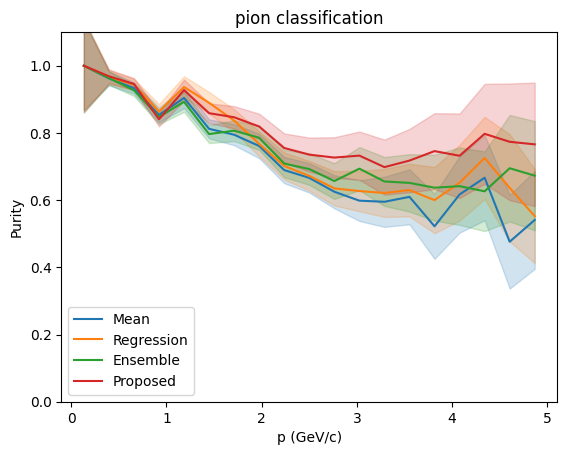

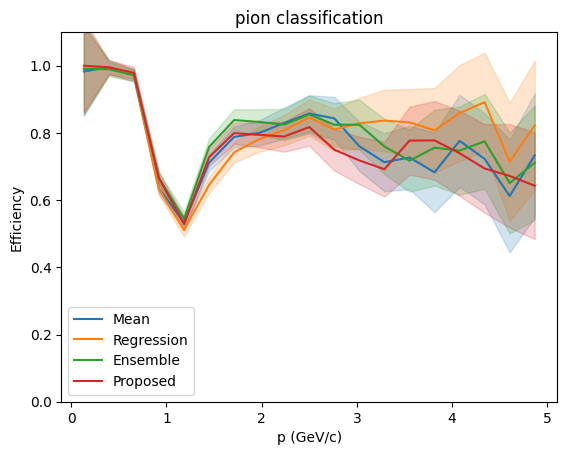

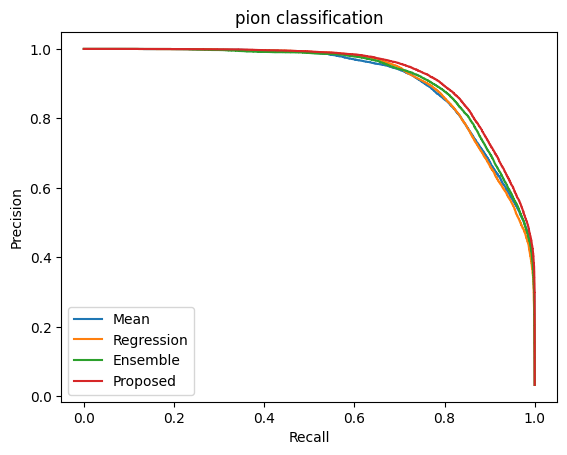

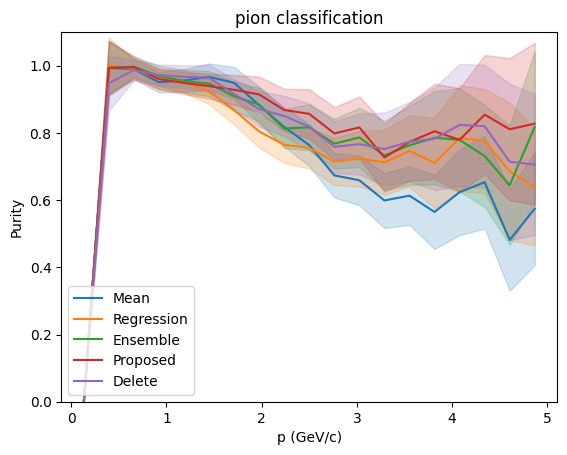

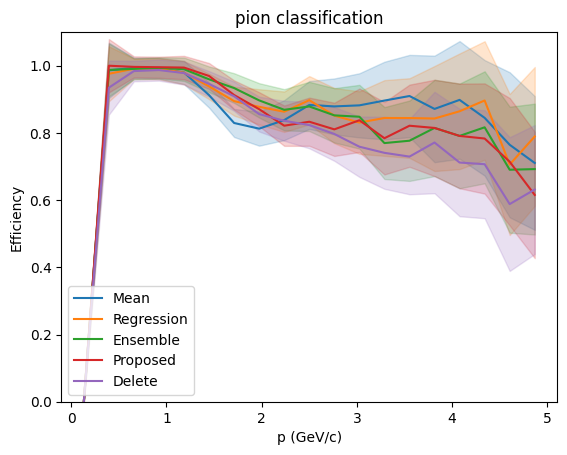

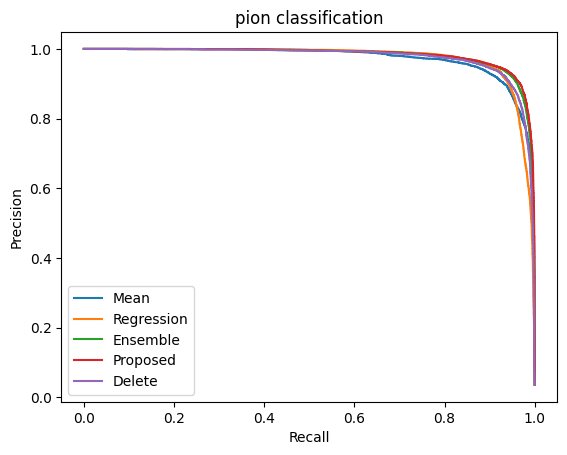

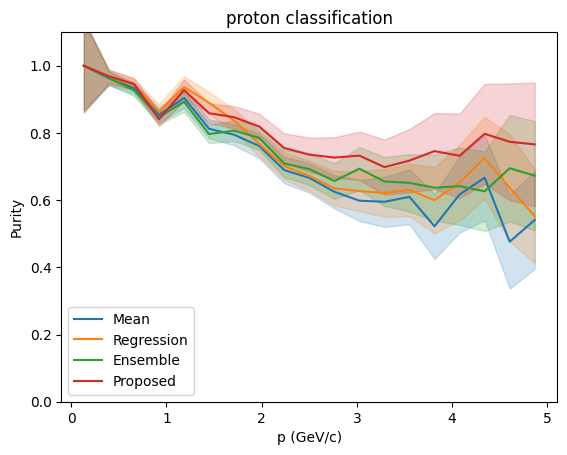

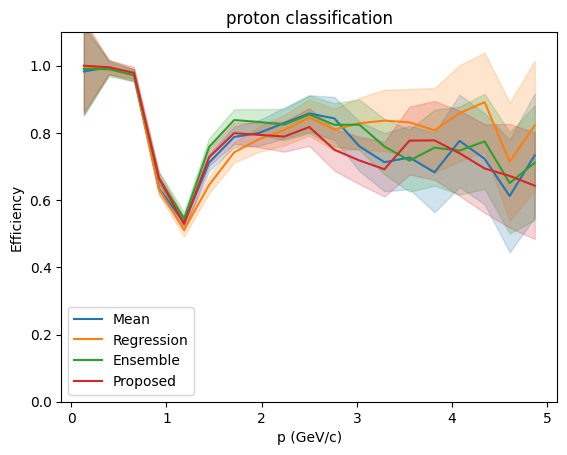

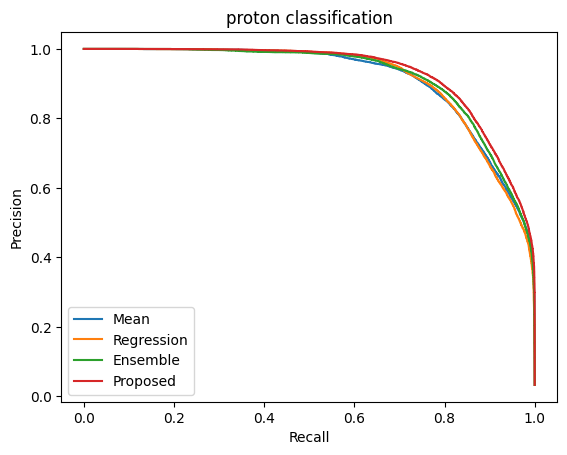

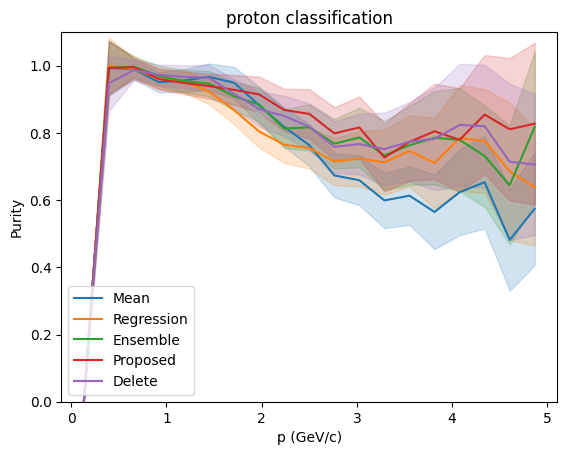

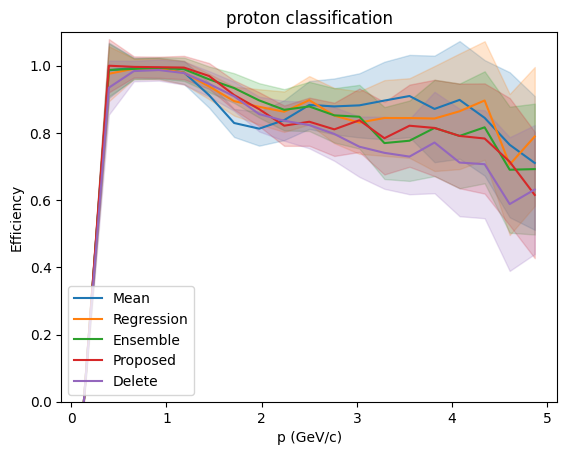

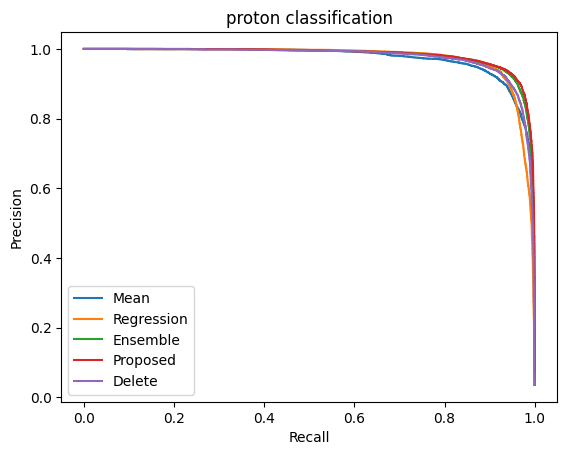

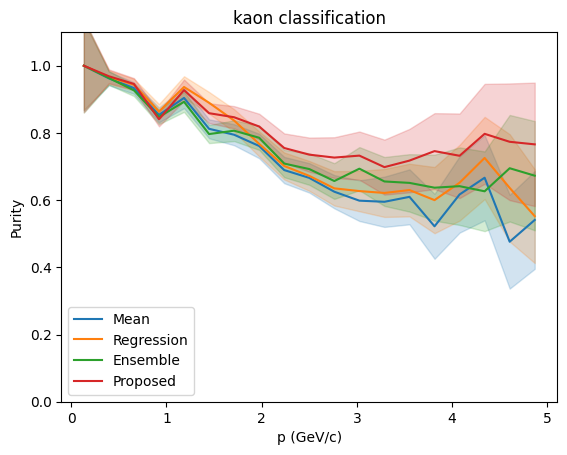

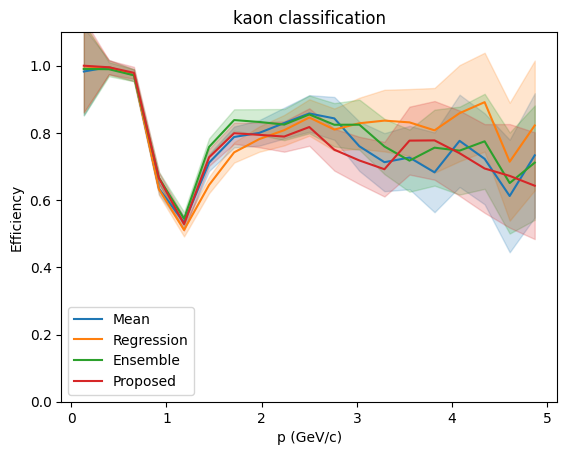

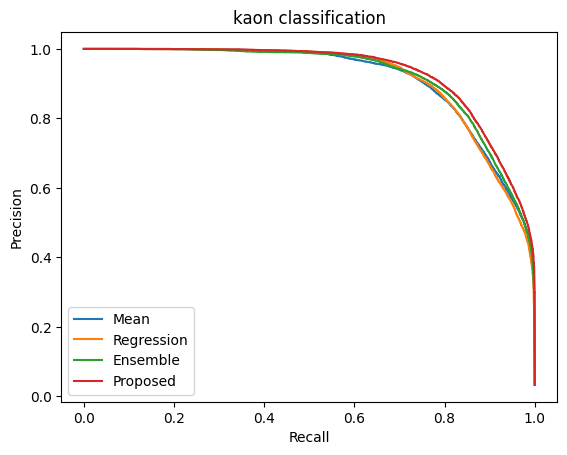

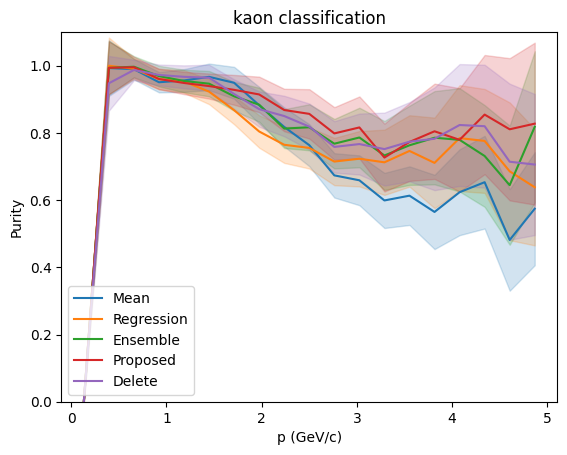

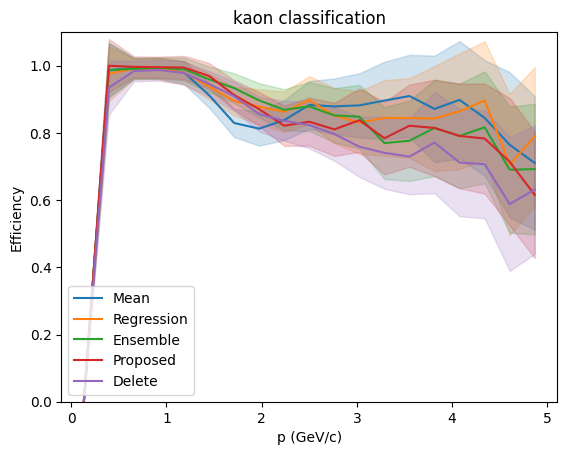

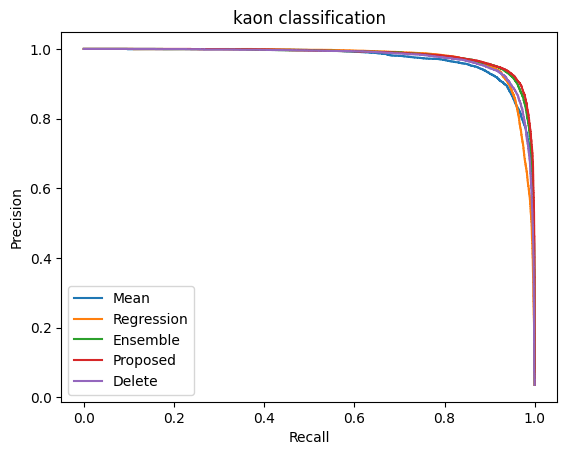

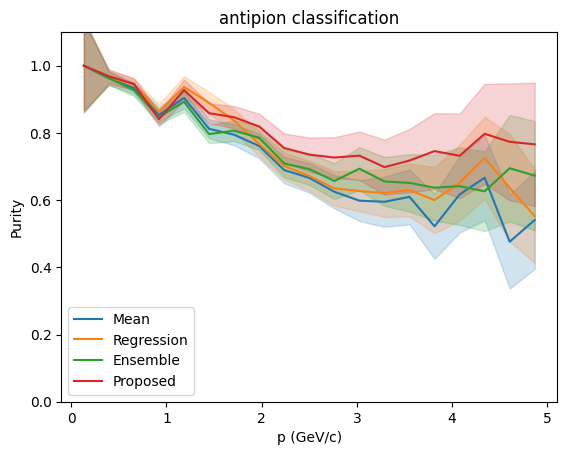

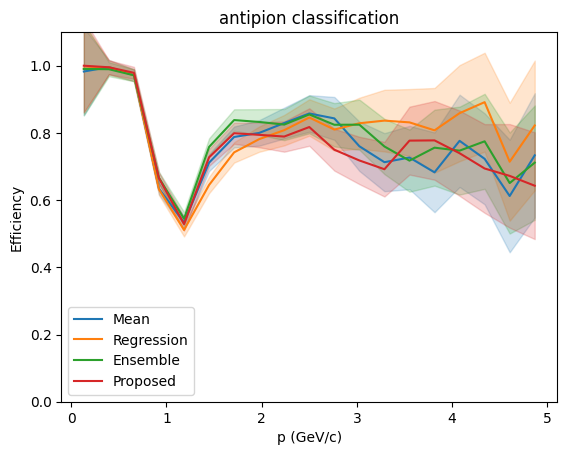

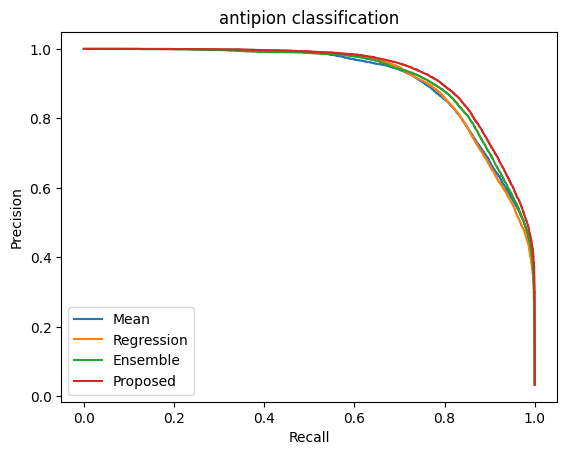

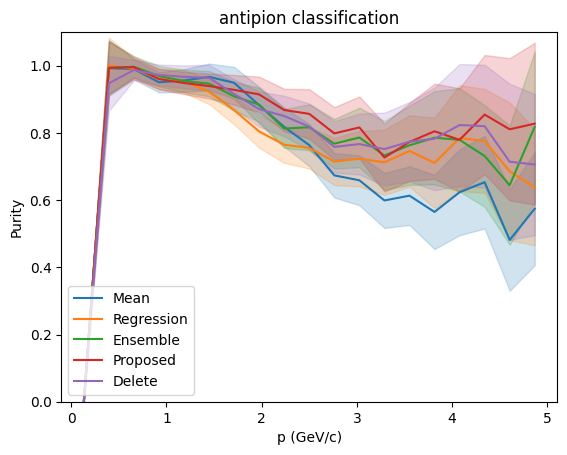

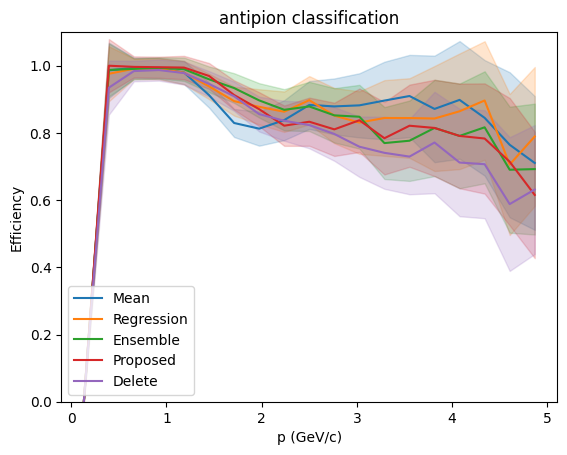

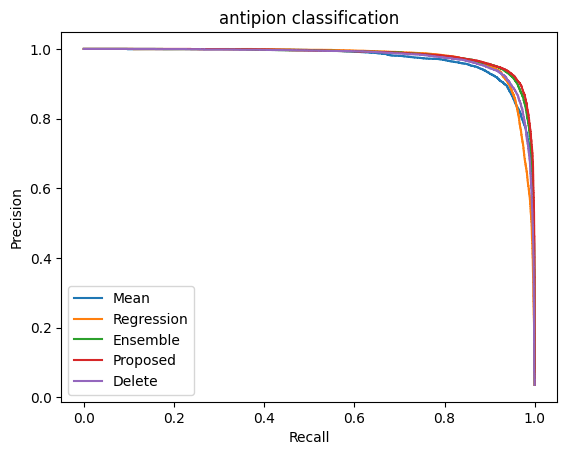

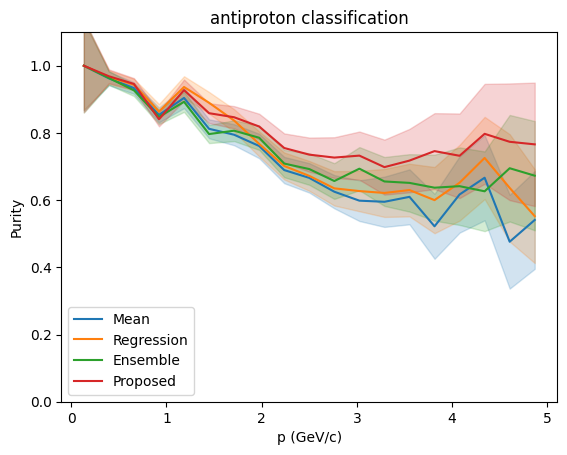

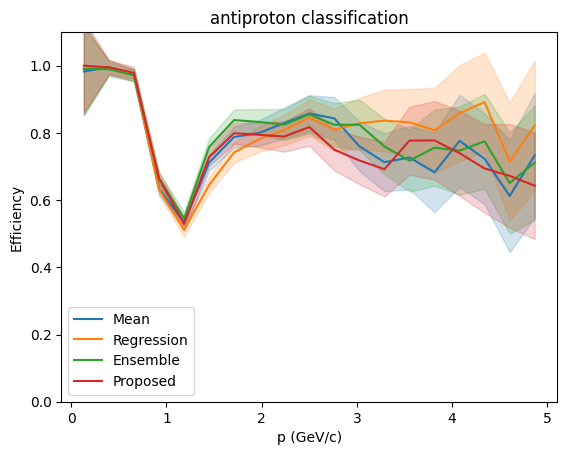

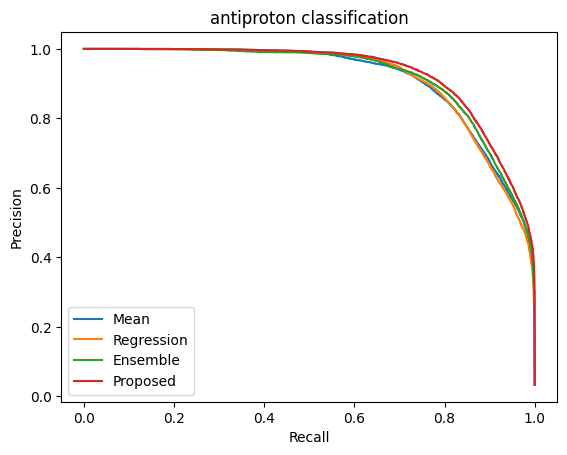

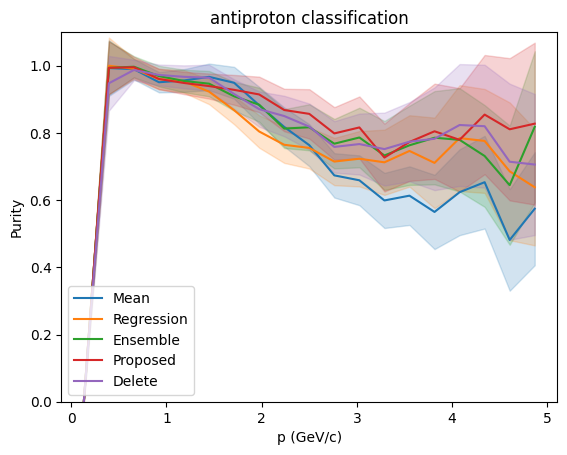

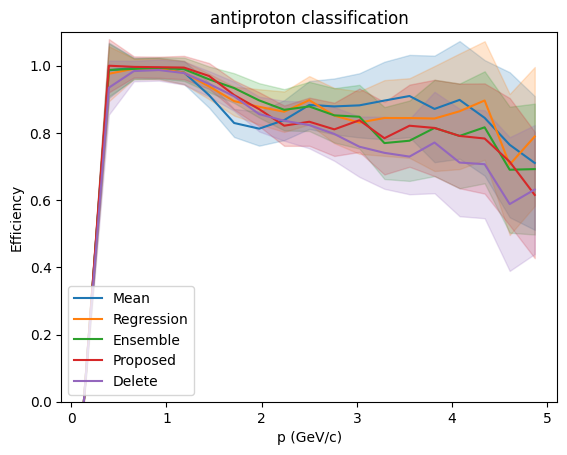

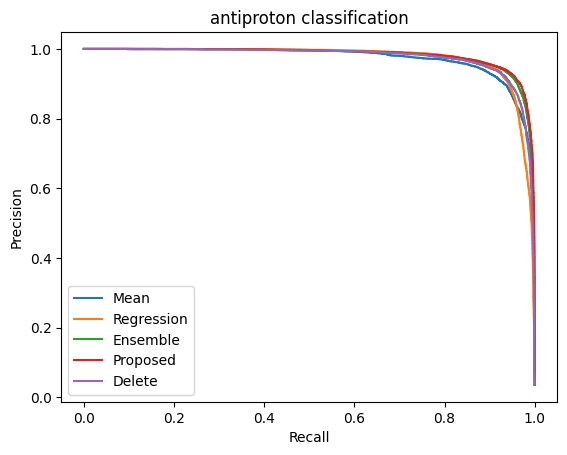

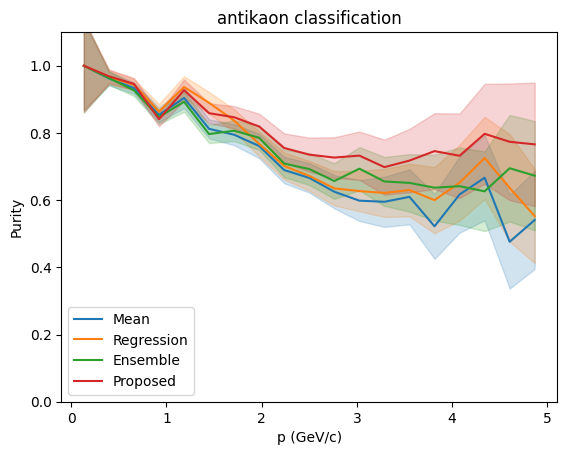

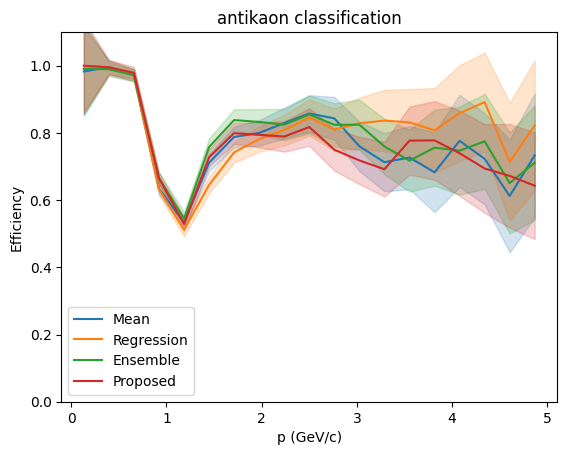

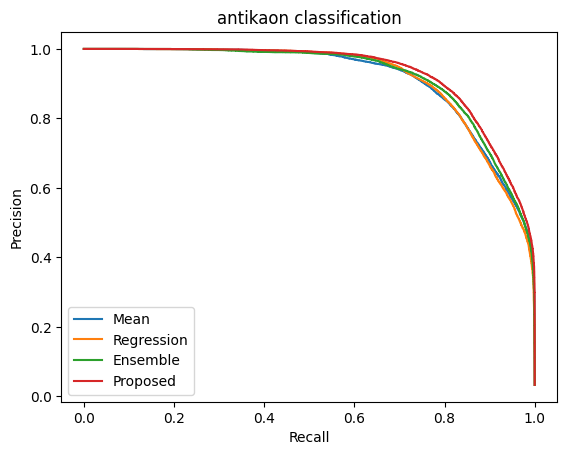

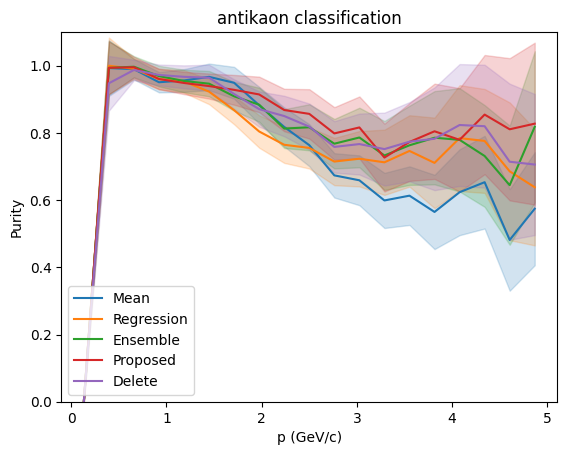

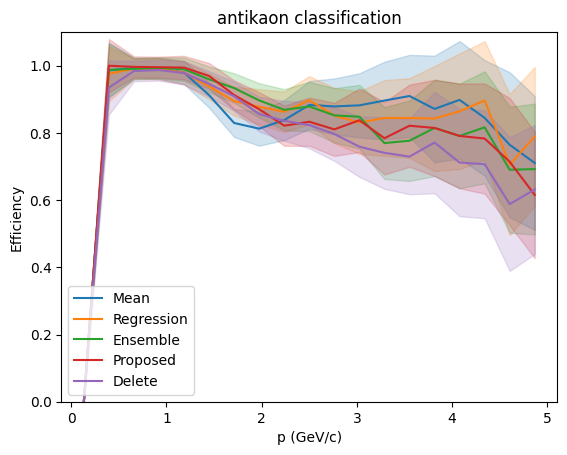

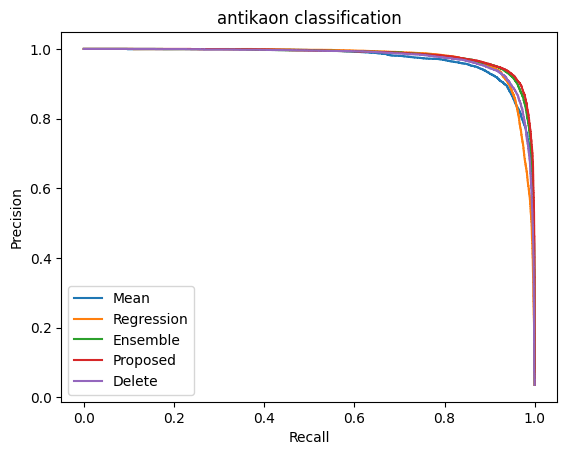

In [9]:
%matplotlib inline
from pdi.visualise import (
    plot_purity_comparison,
    plot_efficiency_comparison,
    plot_precision_recall_comparison,
)

for target_code in TARGET_CODES:
    particle_name = PARTICLES_DICT[target_code]
    for data_type in data_types:
        data = {}
        for exp_name, exp_dict in prediction_data.items():
            if data_type in exp_dict:
                data[exp_name] = exp_dict[data_type]

        save_dir = f"reports/figures/comparison_{data_type}/{particle_name}"   
        os.makedirs(save_dir, exist_ok=True)
        plot_purity_comparison(particle_name, data, save_dir)
        plot_efficiency_comparison(particle_name, data, save_dir)
        plot_precision_recall_comparison(particle_name, data, save_dir)



In [25]:
df = pd.read_csv(f"reports/tables/comparison_metrics.csv", index_col=[0,1], header=[0,1])
subsets = [((part, slice(None)), column) for column in df.columns for part in particle_names]

for dt in data_types:
    save_dir = f"reports/tables/comparison_{dt}"
    os.makedirs(save_dir, exist_ok=True)
    for particle in particle_names:
        results = df.xs(particle).xs(dt, axis='columns')
        columns = [(slice(None), column) for column in metrics]
        style = results.style
        style.format(precision=4)
        for column in columns:
            style = style.highlight_max(column, props='textbf:--rwrap')
        style.to_latex(f"{save_dir}/{particle}_results.tex", hrules=True, clines="all;data")